# Documentation for diskint2

In [1]:
import astropy.units as u
import astropy.constants as const
import numpy as np
import matplotlib.pyplot as plt

import pyRaven as rav

loading specpolFlow package


## 1. Notes on the hardcoded constants in the code

**For the Unno calculation:**

The profile functions that needs to be calculated are 
$$\frac{1}{\sqrt{\pi}}\sum_i S_i H(u_o+u_{B,i} - u_\mathrm{LOS}), $$

where
$$u_{B,i}=\left[ \frac{\Delta \lambda_B}{\lambda_B}\right] * u_B.$$
The term in bracket is what is returned by the Zeeman pattern function: 

$$u_B = \frac{\lambda_B}{\Delta\lambda_D}= \frac{\frac{\lambda_o^2}{c} \left[\frac{e_oB}{4\pi m_e c}\right]}{\frac{\lambda_o v_D}{c}}$$

In the rightmost equation, the first $c$ is in the units that matches the wavelength ($Å$/s) and the bracket terms is the Larmor frequency (Hz) so the $c$ in the bracket is in cm/s. This makes the whole numerator to be in wavelength unit. 

The denominator also needs to be in wavelength units. So the $c$ in the denominator must match the units of $v_D$, so here km/s. 

In the disk integration, $B$ will change from cell to cell, but $\lambda_o$ and $v_D$ are set for a given model. So we can re-write this as:

$$u_B = B[\mathrm{G}] ~~ \frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}~~ \frac{c[\mathrm{km/s}]}{c[\mathrm{Å/s}]} ~~\left[\frac{e_o[\mathrm{esu}]}{4\pi m_e[\mathrm{g}] ~~c[\mathrm{cm/s}]}\right]$$

or

$$u_B = B[\mathrm{G}] ~~ \frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]} ~~\left[\frac{e_o}{4\pi m_e ~~c}\right] = 1.399624\times10^{-7}~~ B[\mathrm{G}] ~~ \frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]} $$

where we ask the astropy unit package below to give us the term in bracket in explicit units of $\frac{\mathrm{km/s}}{\mathrm{G}~ Å}$, so that $\lambda_o$, $v_D$ and later on $B$ will be entered with numerical values in $Å$, km/s, and G. 

In the code, it is setup this way:

$$u_B =  \left[1.399624\times10^{-7}\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}\right] ~~ B[\mathrm{G}], $$
where the constant is `constLorentz` and the term in parenthesis is calculated early on as `perGaussLorentz`.

**For the weak-field calculation:**

The expression for Stokes V is:
$$V(\lambda) = -\lambda_B g_\mathrm{eff} \cos\theta \frac{dI}{d\lambda}$$

However, in our calculations we like to work in Doppler units ($u_o$). So we can first change the derivative from wavelength to velocity (in km/s):

$$V(v) = -\lambda_B g_\mathrm{eff} \cos\theta \frac{dI}{dv} \frac{c[\mathrm{km/s}]}{\lambda_o[Å]}$$

where the units of $c$ matches the units of the velocity. 

Next, we can make the transformation to the thermal Doppler velocity unit ($u_o = v/v_D$):

$$V(u_o) = -\lambda_B g_\mathrm{eff} \cos\theta \frac{dI}{du_o} \frac{c[\mathrm{km/s}]}{v_D[\mathrm{km/s}]\lambda_o[Å]}$$

Now we can expand $\lambda_B$ like above:

$$V(u_o) = - \frac{\lambda_o^2}{c[\mathrm{Å/s}]} \left[\frac{e_oB}{4\pi m_e c[\mathrm{cm/s}]}\right] g_\mathrm{eff} \cos\theta \frac{dI}{du_o} \frac{c[\mathrm{km/s}]}{v_D[\mathrm{km/s}]\lambda_o[Å]}$$

We can now re-organize a bit, noting that $B$ and $\cos\theta$ will be different on the surface, but $\lambda_o$ and $g_\mathrm{eff}$ will be the same for a given model:

$$V(u_o) = - B \cos\theta ~~ g_\mathrm{eff} \frac{\lambda_o}{v_D} ~~ \frac{c[\mathrm{km/s}]}{c[\mathrm{Å/s}]} ~~\left[\frac{e_o[\mathrm{esu}]}{4\pi m_e[\mathrm{g}] ~~c[\mathrm{cm/s}]}\right] \frac{dI}{du_o}  $$

or

$$ V(u_o) =  1.399624\times10^{-7}~~ B[\mathrm{G}] \cos\theta ~~ g_\mathrm{eff}\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]}  \frac{dI}{du_o}$$

As can be seen, for both the Unno and Weak-field method, we can hardcode the same constant. 

In the codes, it is setup this way:

$$ V(u_o) =  \left[1.399624\times10^{-7}~\frac{\lambda_o[Å]}{v_D[\mathrm{km/s}]} \right] g_\mathrm{eff} \cos\theta ~~ B[\mathrm{G}]  \frac{dI}{du_o}$$ 
where the constant is `constLorentz` and the term in parenthesis is calculated early on as `perGaussLorentz`.


In [2]:
G_cgs = u.def_unit('G_cgs', 1 * u.g**0.5/u.cm**0.5/u.s)

constant = ( const.e.esu / (4*np.pi*const.m_e*const.c) ).to(u.km/u.s/(G_cgs*u.AA)) 
print(constant)


# Just checking that muB is what it's supposed to be
# This is typical values for NGC 1624-2 CIV lines. 
B = 20e3*G_cgs
vdop = 6.44 *u.km/u.s # for carbon at 30000K
wave0 = 5811.98 * u.AA

muB = B*wave0/vdop * constant

print(muB)

print(const.c.to(u.km/u.s))

1.3996244936166518e-07 km / (Angstrom G_cgs s)
2.526270051059039
299792.458 km / s


## 2. RT angles

We obtained the B field vectors in LOS coordinates (B_LOS) with the rotation matrix. 

For the weak field, we only need the component of the field in the line of sign (the zLOS direction), so we only need the z component of B_LOS (`B_LOS[2,:]`).

For the Unno solution, we need two values: 
* $\cos(\theta)$ and $\sin(\theta)$, where $\theta$ is the angle between the B-field vector and the z axis and
* $\cos(2\phi)$ and $\sin(2\phi)$, where $\phi$ is the angle between the projection of the Bfield vector in the plane of the sky (xy) and the reference direction (here we'll use the x-axis)

If we use the unit vector in the direction of B, then $\cos(\theta)$ is straightfowardly the z component of B_LOS (`B_LOS[2,:]`). 

We can get $\sin(\theta) = \sqrt{1-\cos^2(\theta)}$. This is also the projection of the Bfield vector on the xy plane (i.e. $\sqrt{\hat{B}_x^2+\hat{B}_y^2}$).

Now, $\cos{\phi}$ is $\frac{\hat{B}_x}{\sin(\theta)}$ 

We can use trig identity to get the cos and sin of the double angles:
$$\cos(2\phi) = 2\cos^2\phi - 1 = 2 \frac{\hat{B}_x^2}{\sin^2(\theta)} - 1 $$


$$\sin(2\phi) = 2\sin\phi\cos\phi = 2 \frac{\hat{B}_x}{\sin(\theta)} \frac{\hat{B}_y}{\sin(\theta)} = 2 \frac{\hat{B}_x\hat{B}_y}{\sin^2(\theta)} $$




## Testing the code

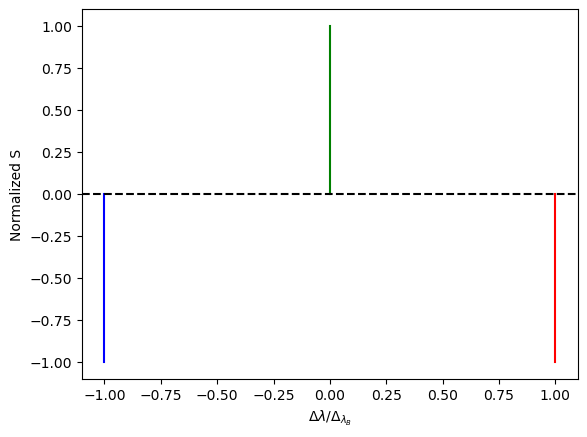

In [40]:
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':50.0,         # the projected rotational velocity
    'vdop':10.0,          # the thermal broadening
    'av':0.05,             # the damping coefficient of the Voigt profile
    'bnu':1.5,             # the slope of the source function with respect to vertical optical depth
    'logkappa':-1.5,          # the line strength parameter
    'ndop':int(100),       # the number of sample point per doppler width for the wavelength array
    'Bpole':1000,
    'incl':30*np.pi/180, #not necessary for loop
    'beta':30*np.pi/180, #not necessary for loop
    'phase':90*np.pi/180 #not necessary for loop
  }

unnoparam = {
    'down':[0, 0, 0],   # the s, j, l of the lower level
    'up':[0, 1, 1],    # the s, j, l of the upper level
    }

weakparam = {
        'geff':1.0
    }
    
param={'general' : genparam,
       'weak' : weakparam,
       'unno': unnoparam # no necessary for loop
       }

pat = rav.pattern.zeeman_pattern(unnoparam['down'], unnoparam['up'])
rav.pattern.plot_zeeman_pattern(pat)

In [41]:
model_unno, testI_unno, testV_unno = rav.diskint2.numerical(param, unno=True)
model_weak, testI_weak, testV_weak = rav.diskint2.numerical(param, unno=False)

Evaluating with unno method...
Max shift due to field: 0.0699812246808326 vdop
Max shift due to vsini: 5.0 vdop
Max velocity needed: 20.0 vdop
Number of wavelength/velocity grid points: 4201
Max velocity needed: 5.0 vdop
Number of wavelength/velocity grid points: 1201


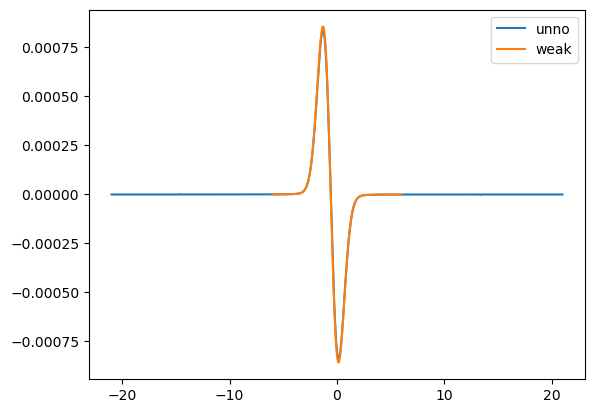

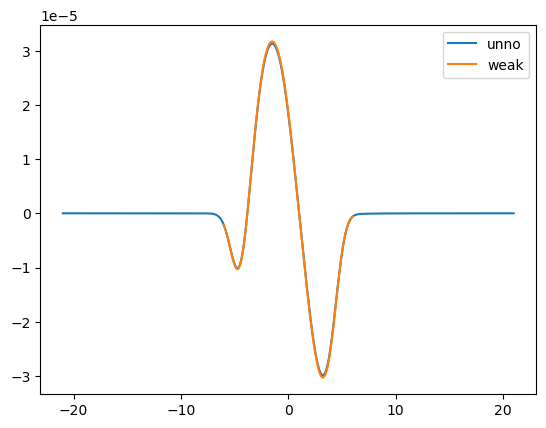

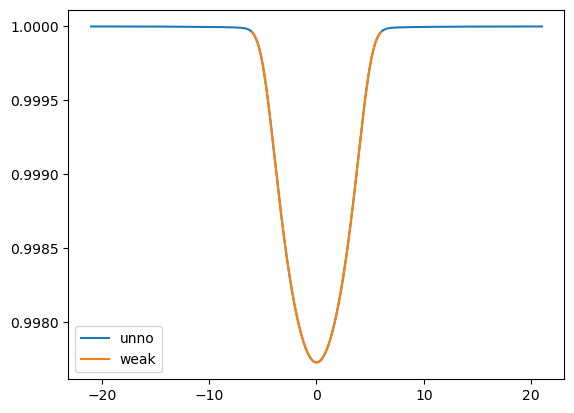

In [42]:
fig, ax = plt.subplots(1,1)

ax.plot(model_unno['uo'], testV_unno, label='unno')
ax.plot(model_weak['uo'], testV_weak, label='weak')
ax.legend(loc=0)

fig, ax = plt.subplots(1,1)

ax.plot(model_unno['uo'], model_unno['V'], label='unno')
ax.plot(model_weak['uo'], model_weak['V'], label='weak')

ax.legend(loc=0)

fig, ax = plt.subplots(1,1)

ax.plot(model_unno['uo'], model_unno['flux'], label='unno')
ax.plot(model_weak['uo'], model_weak['flux'], label='weak')

ax.legend(loc=0)

In [73]:
av = 0.05
kappa = 0.1
S1 = 100.0
small_u = np.linspace(-15,15,15*10*2)
w = rav.profileI.voigt_fara(small_u,av)

phi = w.real
psi = w.imag
d_phi = np.gradient(w.real, small_u)
d_psi = np.gradient(w.imag, small_u)

etaI = 1+kappa*phi
etaV = kappa * d_phi
rhoV = kappa * d_psi

nabla = etaI**4 - (etaI**2*etaV**2) + etaI**2*rhoV**2 - (etaV**2*rhoV**2)
Vup = etaI**2*etaV + etaV*rhoV**2*S1

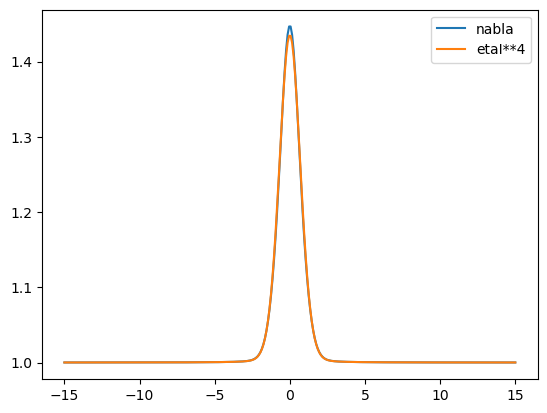

In [74]:
fig, ax = plt.subplots(1,1)

#ax.plot(small_u, etaI**4, label='etaI**4')
#ax.plot(small_u, etaI**2*etaV**2, label='-etaI**2*etaV**2')
#ax.plot(small_u, etaI**2*rhoV**2, label='etaI**2*rhoV**2')
#ax.plot(small_u, etaV**2*rhoV**2, label='etaV**2*rhoV**2')



#ax.plot(small_u, d_phi, label='dphi')
#ax.plot(small_u, d_psi, label='dpsi')
ax.plot(small_u, nabla, label='nabla')
ax.plot(small_u, etaI**4, label='etaI**4')
#ax.plot(small_u, Vup, label='Vup')
#ax.plot(small_u, Vup/nabla, label='V')

ax.legend(loc=0)